In [17]:
import sys,os
import shutil
os.chdir("/home/shared")
sys.path.append("./src")

# clear RBniCS cache
RBNICS_CACHE = "/home/shared/Subfin_NO_GEOMETRY_PARAM"
if os.path.exists(RBNICS_CACHE):
    shutil.rmtree(RBNICS_CACHE)

from dolfin import *
from rbnics import *

In [18]:
import time
import matplotlib.pyplot as plt

import importlib
import inverse_id
importlib.reload(inverse_id)

from inverse_id import plot_sensor, identify, read_sensor, monitor, control_cooling

# Define finite element (FE) model
We consider a steady-state heat transfer problem on a thermal fin using an FE method. The thermal fin model is from RBniCS tutorial (https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/21_thermal_subfin/tutorial_thermal_subfin.ipynb) and we modify the model such that we consider three physical parameters $\mu = (\mu_1, \mu_2, \mu_3) = (\mathbf{Bi_p}, \mathbf{Bi_s}, q)$, excluding all geometric parameters. Here, $\mathbf{Bi_p}, \mathbf{Bi_s}$ are Biot numbers of a primary fin and a subfin, and $q$ is a heat flux applied in the bottom of the primary fin.

In [19]:
class Subfin(EllipticCoerciveProblem):
    def __init__(self, V, **kwargs):
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains = kwargs["subdomains"]
        self.boundaries = kwargs["boundaries"]

        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    def name(self):
        return "Subfin_NO_GEOMETRY_PARAM"

    def compute_theta(self, term): # define physical parameters
        mu = self.mu

        if term == "a":
            theta_a0 = 1.0   # primary fin conductivity
            theta_a1 = 0.9 # subfin conductivity
            theta_a2 = mu[0] # primary fin Biot
            theta_a3 = mu[1] # subfin Biot
            return (theta_a0, theta_a1, theta_a2, theta_a3)

        elif term == "f":
            # heat flux q
            theta_f0 = mu[2] 
            return (theta_f0,)

        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds

        if term == "a":
            # primary fin
            a0 = inner(grad(u),grad(v))*dx(1)+inner(grad(u),grad(v))*dx(2)+inner(grad(u),grad(v))*dx(3)+inner(grad(u),grad(v))*dx(4)
            a1 = inner(grad(u),grad(v))*dx(5)+inner(grad(u),grad(v))*dx(6)+inner(grad(u),grad(v))*dx(7)+inner(grad(u),grad(v))*dx(8)
            a2 = inner(u,v)*ds(2)+inner(u,v)*ds(6)+inner(u,v)*ds(10)
            a3 = inner(u,v)*ds(1)+inner(u,v)*ds(3)+inner(u,v)*ds(4)+inner(u,v)*ds(5)+inner(u,v)*ds(7)+inner(u,v)*ds(8)+inner(u,v)*ds(9)
            return (a0, a1, a2, a3)

        elif term == "f":
            # heat flux
            f0 = v * ds(1)
            return (f0,)

        elif term == "inner_product":
            x0 = inner(grad(u), grad(v)) * dx + inner(u, v) * dx
            return (x0,)

        else:
            raise ValueError("Invalid term for assemble_operator().")

In [20]:
mesh = Mesh("RBniCS/tutorials/21_thermal_subfin/data/subfin1.xml")
subdomains = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_facet_region.xml")
V = FunctionSpace(mesh, "Lagrange", 2) # generate mesh

## Define reduced basis (RB) model

In [21]:
problem = Subfin(V, subdomains=subdomains, boundaries=boundaries) # create problem instance
# define parameter ranges
mu_range = [ 
    (0.1, 5),
    (0.1, 3),
    (0.1, 10)
]
problem.set_mu_range(mu_range)
mu = (2, 1, 8)

# training set up for reduced basis model
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(50)
reduction_method.set_tolerance(1e-6)
reduction_method.initialize_training_set(50)

# train and save RB model
stime = time.time()
reduced_problem = reduction_method.offline()
etime = time.time()
print('RB training time: ', etime-stime)
print("RB basis size:", reduced_problem.N)

# define FE model instance
truth_problem = reduced_problem.truth_problem

=          Subfin_NO_GEOMETRY_PARAM POD-Galerkin offline phase begins          =

###################################### 0 #######################################
truth solve for mu = (0.893316386167412, 0.26964087037866347, 2.372720784151996)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (2.6781416134691045, 1.1841561074665086, 6.223125299959232)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (4.7506617611789785, 0.6144894315874646, 5.682998239033454)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (3.0571897121470037, 0.33622589151365745, 9.170557799684248)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (0.4173761262603407, 1.3855482276687596, 7.153020825004589)
update 

# Digital twin
We present the following two digital twin scenarios. We assume that sensor output from FE model represents a true sensor ouput from a physical asset. We use trained RB model for inverse identification to cheaply identify the current heat flux and use FE model to monitor the temperature field. If the maximum temperature
1) exceeds a specific threshold, cooling is increased by increasing Biot numbers (this imitates increasing coolant flow rate)
2) falls below a specific threshold, cooling is reduced by reducing Biot numbers.

After control action, we use FE model to display the current temperature field.

## Locate sensor

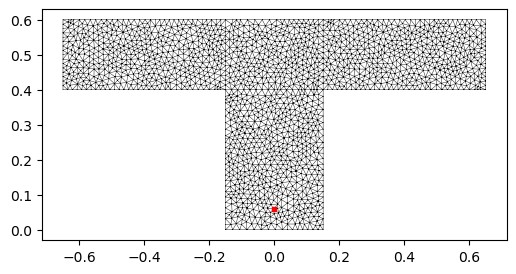

In [22]:
# define sensor locations
sensor_loc = [448]
plot_sensor(mesh, sensor_loc)

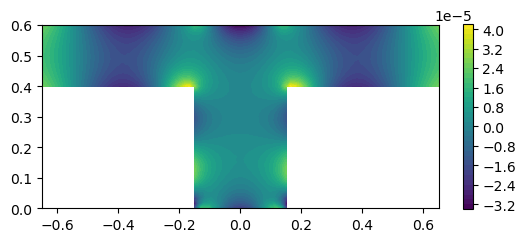

In [23]:
# FE model prediction at mu = (2.5, 1.5, 1)
truth_problem.set_mu(tuple(mu))
u_fe = truth_problem.solve()
# p = plot(u_fe)
# plt.colorbar(p,shrink=0.5)

# RB model prediction at mu = (2.5, 1,5, 1)
reduced_problem.set_mu(tuple(mu))
u_rb_coeffs = reduced_problem.solve()
# p = plot(u_rb_coeffs,reduced_problem=reduced_problem)
# plt.colorbar(p,shrink=0.5)

# Reconstruct RB solution in FE space
V = truth_problem.V # define V using the FE space
u_rb_reconstruct = Function(V)
u_rb_reconstruct.vector()[:] = 0.0
for i, coeff in enumerate(u_rb_coeffs):
    u_rb_reconstruct.vector().axpy(coeff,
                                   reduced_problem.basis_functions[i].vector())

# plot error
error = u_fe - u_rb_reconstruct
mesh = V.mesh()
Vproj = FunctionSpace(mesh, "Lagrange", 2)
error_proj = project(error, Vproj)
plt.figure()
p = plot(error_proj)
plt.colorbar(p, shrink=0.5)

## Scenario 1: High device load (Fin overheated)

### Get sensor measurement

In [24]:
# set up scenario that q=8
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=8, sensor_loc=sensor_loc
    )

print("sensor measurement:", y_true)

sensor measurement: [1.50885295]


### Identify current heat flux by solving inverse problem

In [25]:
stime = time.time()
mu = identify(reduced_problem, sensor_loc, y_true, mu, initial_guess=1.0, rb=True)
print("estimated q =", mu[2])
etime = time.time()

Identification time: 0.46706485748291016
estimated q = 7.99998410228014


### Monitor temperature field based on identified heat flux
Identify the current heat flux $q$ by solving least-squares based inverse problem.

system parameters for monitoring: [2, 1, 7.99998410228014]


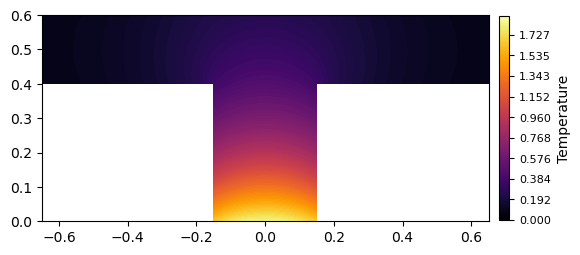

current maximum temperature: 1.8429420756528372


In [26]:
# monitor the tempearture field based on identified q
truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu)

## Control cooling 
If the subfin is determined to be overheated based on the inverse identification, we increase the cooling.

In [ ]:
mu, truth_solution, max_temp, _, _ = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)

## Scenario 2: Low device load (Fin cooled down)

In [ ]:
# get updated measurement -- the device load reduced
# set up scenario that q is reduced to 2
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=2, sensor_loc=sensor_loc
    )
print("new measurement:", y_true)

# identify q
mu = identify(reduced_problem, sensor_loc, y_true, mu, initial_guess=1.0, rb=True)
print("estimated q =", mu[2])


# monitor the temperature field based on newly identified q
truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu
    )

# control cooling -- reduce cooling
mu, truth_solution, max_temp, _, _ = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)